<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span> Import Necessaries</b>

In [3]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import missingno as msno
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import iplot

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.resnet50 import ResNet50
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


modules loaded


<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> Setting the Enviroment</b>

In [4]:
tf.__version__

'2.11.0'

In [5]:
train_data_path = '/kaggle/input/dataset/train'
test_data_path = '/kaggle/input/dataset/test'
valid_data_path = '/kaggle/input/dataset/val'

In [6]:
labels = os.listdir(valid_data_path)

Creating data working directory

In [7]:
data_path = '/kaggle/working/data'

if not os.path.exists(data_path):
    os.mkdir(data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")

Created Succesfulley!


In [8]:
normal_data_path = '/kaggle/working/data/Normal'
oscc_data_path = '/kaggle/working/data/OSCC'

if not os.path.exists(normal_data_path):
    os.mkdir(normal_data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")
    
if not os.path.exists(oscc_data_path):
    os.mkdir(oscc_data_path)
    print("Created Succesfulley!")
else:
    print("Folder already exist")

Created Succesfulley!
Created Succesfulley!


Moving all the images to the data working directory

In [9]:
def move_data(d_path, saved_path):
    for i in labels:
        images = os.listdir(d_path + '/' + i)
        for j in images:
            path = d_path +'/' + i
            img = cv2.imread(path + '/' + j)
            s_path = saved_path + '/' + i + '/' + j
            cv2.imwrite(s_path, img)

In [10]:
move_data(train_data_path, data_path)

In [11]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

4946


In [12]:
move_data(test_data_path, data_path)

In [13]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5072


In [14]:
move_data(valid_data_path, data_path)

In [15]:
norm_path = len(os.listdir(data_path + '/' + labels[0]))
oscc_path = len(os.listdir(data_path + '/' + labels[1]))
print(norm_path+oscc_path)

5192


<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> EDA</b>

<a id="4.1"></a>
### <b>4.1 <span style='color:#B21010'>||</span> Define data path and dataset name</b>

In [16]:
data_dir = '/kaggle/working/data'
ds_name = 'Oral Cancer'

<a id="4.2"></a>
### <b>4.2 <span style='color:#B21010'>||</span> Create Dataframe for the dataset</b>

In [17]:
# Generate data paths with labels

def generate_data_paths(data_dir):
    
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)
            
    return filepaths, labels


filepaths, labels = generate_data_paths(data_dir)

In [18]:
def create_df(filepaths, labels):

    Fseries = pd.Series(filepaths, name= 'filepaths')
    Lseries = pd.Series(labels, name='labels')
    df = pd.concat([Fseries, Lseries], axis= 1)
    return df

df = create_df(filepaths, labels)

In [19]:
df.head()

,filepaths,labels
0,/kaggle/working/data/Normal/aug_670_7168.jpg,Normal
1,/kaggle/working/data/Normal/aug_173_3909.jpg,Normal
2,/kaggle/working/data/Normal/aug_167_7596.jpg,Normal
3,/kaggle/working/data/Normal/Normal_100x_30.jpg,Normal
4,/kaggle/working/data/Normal/aug_101_4143.jpg,Normal


<a id="4.3"></a>
### <b>4.3 <span style='color:#B21010'>||</span> Display Number of Examples in the dataset</b>

<a id="4.4"></a>
### <b>4.4 <span style='color:#B21010'>||</span> Display Number of Classes in the dataset</b>

<a id="4.5"></a>
### <b>4.5 <span style='color:#B21010'>||</span> Display count of images in each class of the dataset</b>

<a id="4.6"></a>
### <b>4.6 <span style='color:#B21010'>||</span> Visualize Each Class in the dataset</b>

**The data is Balanced**

<a id="4.7"></a>
### <b>4.7 <span style='color:#B21010'>||</span> Check Null values in the dataframe</b>

In [20]:
def check_null_values(df, name='df'):
    
    num_null_vals = sum(df.isnull().sum().values)
    
    if not num_null_vals:
        print(f"The {name} dataset has no null values")
    
    else:
        print(f"The {name} dataset has {num_null_vals} null values")
        print('-'*70)
        print('Total null values in each column:\n')
        print(df.isnull().sum())
        

check_null_values(df, ds_name)

The Oral Cancer dataset has no null values


<a id="4.8"></a>
### <b>4.8 <span style='color:#B21010'>||</span> Visualize Null values</b>

<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span>Split dataframe into train, valid, and test</b>

In [21]:
def num_of_classes(df, name='df'):
    print(f"The {name} dataset has {len(df['labels'].unique())} classes")
    
num_of_classes(df, ds_name)

The Oral Cancer dataset has 2 classes


In [22]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Oral Cancer dataset has 2 classes
The Validation Oral Cancer dataset has 2 classes
The Testing Oral Cancer dataset has 2 classes


In [23]:
# train dataframe
train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123)

In [24]:
num_of_classes(train_df, "Training "+ds_name)
num_of_classes(valid_df, "Validation "+ds_name)
num_of_classes(test_df, "Testing "+ds_name)

The Training Oral Cancer dataset has 2 classes
The Validation Oral Cancer dataset has 2 classes
The Testing Oral Cancer dataset has 2 classes


In [25]:
def classes_count(df, name='df'):
    
    print(f"The {name} dataset has: ")
    print("="*70)
    print()
    for name in df['labels'].unique():
        num_class = len(df['labels'][df['labels'] == name])
        print(f"Class '{name}' has {num_class} images")
        print('-'*70)
        
classes_count(df, ds_name)

The Oral Cancer dataset has: 

Class 'Normal' has 2494 images
----------------------------------------------------------------------
Class 'OSCC' has 2698 images
----------------------------------------------------------------------


In [26]:
classes_count(train_df, 'Training '+ds_name)

The Training Oral Cancer dataset has: 

Class 'Normal' has 1775 images
----------------------------------------------------------------------
Class 'OSCC' has 1859 images
----------------------------------------------------------------------


In [27]:
classes_count(valid_df, 'Validation '+ds_name)

The Validation Oral Cancer dataset has: 

Class 'OSCC' has 420 images
----------------------------------------------------------------------
Class 'Normal' has 359 images
----------------------------------------------------------------------


In [28]:
classes_count(test_df, 'Testing '+ds_name)

The Testing Oral Cancer dataset has: 

Class 'Normal' has 360 images
----------------------------------------------------------------------
Class 'OSCC' has 419 images
----------------------------------------------------------------------


<a id="6"></a>
## <b>6 <span style='color:#B21010'>||</span>Create Image Data Generator</b>

In [29]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# Recommended : use custom function for test data batch size, else we can use normal batch size.
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

# This function which will be used in image data generator for data augmentation, it just take the image and return it again.
def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar,
                           horizontal_flip=True)

ts_gen = ImageDataGenerator(preprocessing_function= scalar)

train_gen = tr_gen.flow_from_dataframe(train_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, 
                                       x_col= 'filepaths', 
                                       y_col= 'labels', 
                                       target_size= img_size, 
                                       class_mode= 'categorical',
                                       color_mode= 'rgb', 
                                       shuffle= True, 
                                       batch_size= batch_size)

# Note: we will use custom test_batch_size, and make shuffle= false
test_gen = ts_gen.flow_from_dataframe(test_df, 
                                      x_col= 'filepaths', 
                                      y_col= 'labels', 
                                      target_size= img_size, 
                                      class_mode= 'categorical',
                                      color_mode= 'rgb', 
                                      shuffle= False, 
                                      batch_size= test_batch_size)

Found 3634 validated image filenames belonging to 2 classes.
Found 779 validated image filenames belonging to 2 classes.
Found 779 validated image filenames belonging to 2 classes.


<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span>Visualize Training dataset</b>

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span>Model Structure</b>

<a id="8.1"></a>
### <b>8.1 <span style='color:#B21010'>||</span>Generic Model Creation</b>

In [30]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

efficentNet_model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

efficentNet_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

efficentNet_model.summary()

43941136/43941136 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization (BatchN  (None, 1536)             6144      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 11,183,665
Trainable params: 11,093,290
Non

<a id="8.2"></a>
### <b>8.2 <span style='color:#B21010'>||</span>Define Early Stop</b>

In [31]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=10, 
                               restore_best_weights=True,
                               mode='min',
                              )

<a id="8.3"></a>
### <b>8.3 <span style='color:#B21010'>||</span>Train Model</b>

In [39]:
batch_size = 128   # set batch size for training
epochs = 50   # number of all epochs in training

history = efficentNet_model.fit(x=train_gen,
                    epochs= epochs,
                    verbose= 1,
                    validation_data= valid_gen, 
                    validation_steps= None,
                    shuffle= False,
                    batch_size= batch_size)

Epoch 1/50
228/228 [==============================] - 63s 274ms/step - loss: 0.8653 - accuracy: 0.9651 - val_loss: 0.7149 - val_accuracy: 0.9833
Epoch 2/50
228/228 [==============================] - 62s 272ms/step - loss: 0.6824 - accuracy: 0.9714 - val_loss: 0.5884 - val_accuracy: 0.9820
Epoch 3/50
228/228 [==============================] - 62s 271ms/step - loss: 0.5680 - accuracy: 0.9692 - val_loss: 0.4863 - val_accuracy: 0.9833
Epoch 4/50
228/228 [==============================] - 62s 273ms/step - loss: 0.4633 - accuracy: 0.9761 - val_loss: 0.3988 - val_accuracy: 0.9846
Epoch 5/50
228/228 [==============================] - 62s 273ms/step - loss: 0.3965 - accuracy: 0.9766 - val_loss: 0.3411 - val_accuracy: 0.9807
Epoch 6/50
228/228 [==============================] - 62s 273ms/step - loss: 0.3349 - accuracy: 0.9805 - val_loss: 0.2880 - val_accuracy: 0.9859
Epoch 7/50
228/228 [==============================] - 62s 272ms/step - loss: 0.2886 - accuracy: 0.9818 - val_loss: 0.2592 - val_ac

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span>Evaluate Model</b>

<a id="9.1"></a>
### <b>9.1 <span style='color:#B21010'>||</span>Plot accuarcy and loss curve </b>

In [40]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# # Plot training history

# plt.figure(figsize= (20, 8))
# plt.style.use('fivethirtyeight')

# plt.subplot(1, 2, 1)
# plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
# plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
# plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
# plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
# plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.tight_layout
# plt.show()

<a id="9.2"></a>
### <b>9.2 <span style='color:#B21010'>||</span>Model Accuarcy</b>

In [41]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = efficentNet_model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = efficentNet_model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = efficentNet_model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 [==============================] - 5s 261ms/step - loss: 0.1012 - accuracy: 0.9833
Train Loss:  0.05162864550948143
Train Accuracy:  0.9967105388641357
--------------------
Validation Loss:  0.0614435188472271
Validation Accuracy:  0.9934210777282715
--------------------
Test Loss:  0.10120585560798645
Test Accuracy:  0.9833119511604309


<a id="9.3"></a>
### <b>9.3 <span style='color:#B21010'>||</span>Get Prediction</b>

In [42]:
preds = efficentNet_model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)

<a id="9.4"></a>
### <b>9.4 <span style='color:#B21010'>||</span>Confussion Matrix</b>

<a id="9.5"></a>
### <b>9.5 <span style='color:#B21010'>||</span>Classification Report</b>

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span>Save the Model</b>

In [43]:
efficentNet_model.save_weights('my_model_weights.h5')

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span>Load the model and Predict the Inputs</b>

1/1 [==============================] - 0s 38ms/step


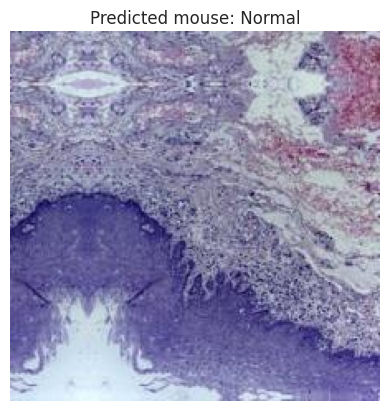

In [44]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

def predict_and_display(image_path, model, class_labels):
    
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)
    
    predicted_class_label = class_labels[predicted_class_index]
    
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted mouse: {predicted_class_label}")
    plt.show()

# Load your trained model
efficentNet_model.load_weights('/kaggle/working/my_model_weights.h5')

# Define your class labels (e.g., ['car', 'truck', ...])
class_labels = ['Normal', 'Oral Cancer']

# Replace 'path_to_test_image' with the path to the image you want to test
image_path_to_test = '/kaggle/working/data/Normal/aug_356_3394.jpg'
predict_and_display(image_path_to_test, efficentNet_model, class_labels)

1/1 [==============================] - 0s 38ms/step


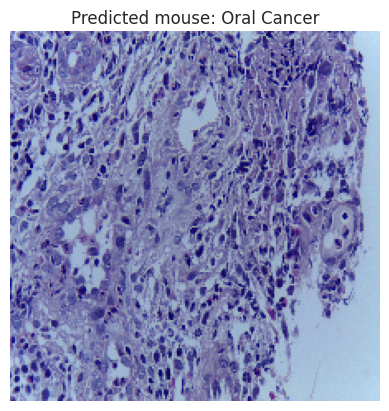

In [45]:
image_path_to_test = '/kaggle/working/data/OSCC/OSCC_400x_54.jpg'
predict_and_display(image_path_to_test, efficentNet_model, class_labels)